## Three esstential computer vision tasks

* Image classification
* Image segmentation
* Object detection

Deep learning for computer vision also encompasses a number of somewhat more niche tasks besides these three, such as image similarity scoring (estimating how visually similar two images are), keypoint detection (pinpointing attributes of interest in an image, such as facial features), pose estimation, 3D mesh estimation, and so on.

## An image segmentation example

Image segmentation with deep learning is about using a model to assign a class to each pixel in an image, thus segmenting the image into different zones (such as "background" and "foreground", or "road", "car", and "sidewalk").

There are two different flavors of image segmentation:
* *Semantic segmentation,* where each pixel is independently classified into semantic category, like "cat". If there are two cats in the image, the corresponding pixels are all mapped to the same generic "cat" category.
* *Instance segmentation,* which seeks not only to classify image pixels by category, but alse to parse out individual object instances. In an image with two cats in it, instance segmentation would treat "cat 1" and "cat 2" as two separate classes of pixels.

A ***segmentation*** mask is the image-segmentation equivalent of a label.

In [ ]:
# Downloading and uncompressing our dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
# Let's prepare the list of input file paths, as well as the list of the corresponding mask file paths:
import os

input_dir = "images/"
target_dir = "annotations/trimaps"

input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

In [ ]:
# Now, what does one of these inputs and its mask look like?
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off") 
plt.imshow(load_img(input_img_paths[9])); # Display inut image number 9

In [ ]:
# And here is it's correnponding target
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") - 1) * 127
  plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
input_img_paths[:5], target_paths[:5]

In [ ]:
import numpy as np
import random
from tensorflow.keras.utils import load_img, img_to_array

# Setting the img_size
img_size = (200, 200) # A 200x200 square img
num_imgs = len(input_img_paths) # Total number of img paths downloaded from the dataset

# Shuffling the paths so that the CNN can learn 
# at random and doesn't form some particular patterns
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  """
  Transform an image from it's reference path in disk to an 
  actual array of numbers, because DNNs only learn with numbers
  and not actual images.
  """
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
  """
  Transform a target image from it's reference path in disk
  to an actual array of numbers, because DNNs only learn with 
  numbers and not actual images.
  """
  img = img_to_array(
      load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype("uint8") - 1 
  return img

# Initializing the initial input_imgs tensor with (7390, 200, 200, 3) shape
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

# Setting the actual values of the image array to the inputs_imgs
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])


num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

**Convolution** decreases the size of the input layer.
* When convulating an input of size `(200x200)` with a `kernel_size` of `3x3` it will result in `(198x198)`.
* When convulating an input of size `(200x200)` with a `kernel_size` of `5x5` it will result in `(196x196)`.

But by setting the `padding="same"` the size after the convolution doesn't change.
* A `(200x200)` size input convoluted with a `kernel_size` of `3x3` and with a `padding="same"` results with an output size of `(200x200)`.

In [ ]:
# Now it's time to define our model
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

  model = keras.Model(inputs, outputs)
  return model

In [ ]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

### Why we used strides to downsample instead of a MaxPooling2D layer?

>We do this because, in the case of image segmentation, we care a lot about the *spatial location* of information in the image, since we need to produce per-pixel target masks as output of the model. When you do 2 x 2 maxpooling, you are completely destroying location information within each pooling window: you return one scalar value per window, with zero knowledge of which of the four locations in the windows the value came from. So while max pooling layers perform well for classification tasks, they would hurt quite a bit for a segmentation task. Meanwhile, strided convolutions do a better job at downsampling feature maps while retaining location information.

In [ ]:
# Compile the model
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy")

# Make the callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

# Fit the model
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend();

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 20
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.show()

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask);
    
display_mask(mask)

## Modern convnet architecture pattterns

A model's "architecture" is the sum of the choices that went into creating itL which layers to use, how to configure them, and in what arrangement to connect them. These choices define the *hypothesis space* of your model: the space of possible functions that gradient descent can search over, parameterized by the model's weights.

Model architecture is often the difference between success and failure. If you make inappropriate choices, your model may be stuck with suboptimal metrics, and amount of training data will save it. Inversely, a good model architecture will accelerate learning and will enable your model to make efficient use of the training data available, reducing the need for large datasets. A good model architecture is one that reduces the size of the search space or otherwise make it easier to converge to a good point of the search space. Just like feature engineering and data curation, model architecture is all about making the problem simpler for gradient descent to solve. And remember that gradient descent is a pretty stupid search process, so it needs all the help it can get.

### Modularity, hierarchy, and resue

If you want to make a complex system simpler, there's a universal recipe you can apply: just structure your amorphous soup of complexity into *modules*, organize the modules into a *hierarchy*, and start *reusing* the same modules in multiple places as appropriate ("reuse" is another word for *abstraction* in this context).

### Residual connections

`y = f4(f3(f2(f1(x))))`

To adjust `f1`, you'll need to percolate error information through `f2`, `f3`, and `f4`. However, each successive function in the chain introduces some amount of noise. If your function chain is too deep, this noise starts overwhelming gradient information, and backpropagation stops working. Your model won't train at all. This is the ***vanishing gradients*** problem.

The fix is simple: just force each function in the chain to be nondestructive - to retain a noiseless version of the information contained in the previous input. The easiest way to implement this is to use a *residual connection*. It's dead easy: just add the input of a layer or block of layers back to its output. The *residual* connection acts as in *information shorcut* around destructive or noisy blocks (such as blocks that contain `relu` activations or `dropout` layers), enabling error gradient information from early layers to propagate noiselessly through a deep network.

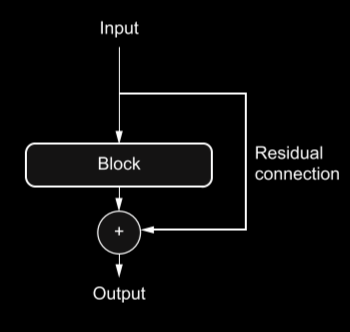

In [ ]:
# A residual connection in pseudocode
x = "some input"
residual = x # Save a pointer to the original input. This is called the residual
x = block(x) # This computation block can potentially be destructive or noisy, and that's fine
x = add([x, residual]) # Add the original input to the layer's output: the final output will thus always preserve full information about the original input.

>**Note:** Adding the input back to the output of a block implies that the output should have the same shape as the input. However, this is not the case if your block includes convolutional layers with an increased number of filters, or a max pooling layer. In such cases, use a `1 x 1 Conv2D` layer with no activation to linearly project the residual to the deired output shape. You'd typically use `padding="same"` in the convolution layers in your target block so as to avoid spatial downsampling due to padding, and you'd use strides in the residual projection to match and downsampling caused by a max pooling layer.

In [ ]:
# Residual block where the number of filters changes
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3)) 
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x # Set aside the residual
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) # This is the layer around which we create a residual connection: it increases the number of output filters from 32 to 64. Note that we use padding="same" to avoid downsampling due to padding.
residual = layers.Conv2D(64, 1)(residual) # The residual only had 32 filters, so we use a 1 x 1 Conv2D to project it to the correct shape.
x = layers.add([x, residual])

In [ ]:
# Case where the target block includes a max pooling layer
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x # Set aside the residual
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) 
x = layers.MaxPooling2D(2, padding="same")(x) # This is the block of two layers around which we create a residual connection: it includes a 2 x 2 max pooling layer. Note that we use padding="same" in both the convolution layer and the max pooling layer to avoid downsampling due to padding.
residual = layers.Conv2D(64, 1, strides=2)(residual) # We use strides=2 in the residual projection to match the downsampling created by the max pooling layer
x = layers.add([x, residual]) # Now the block output and the residual have the same shape and can be added.

In [ ]:
# A concrete example
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs) 

def residual_block(x, filters, pooling=False): # Utitlity function to apply a convolution block with a residual connection, with an option to add max pooing
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x) 
        residual = layers.Conv2D(filters, 1, strides=2)(residual) # If we use max pooling, we add a strided convolution to project the residual to the expected shape
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual) # If we don't use max pooling, we only project the residual if the number of channels has changed
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True) # First block
x = residual_block(x, filters=64, pooling=True) # Second block; note the increasing filter count in each block
x = residual_block(x, filters=128, pooling=False) # The last block doesn't need a max pooling layer, since we will apply global pooling right after it.

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

With residual connections, you can build networks of arbitrary depth, without having to worry about vanishing gradients.

### Batch Normalization

Normalization is a broad category of methods seek to make different samples seen by a machine learning model more similar to each other, which helps the model learn and generalize well to new data.

>**Batch normalization** is a type of layer which can adaptively normalize data even as the mean and variance change over time during training. During training, it uses the mean and variance of the current batch of data to normalize samples, and during inference (when a big enough batch of representative data may not be available), it uses an exponential moving average of the batch-wise mean and variance of the data seen during training.

In [ ]:
# How to use batch normalization: no bias vector and the activation comes last
x = layers.Conv2D(32, 3, use_bias=False)(x) # Note the lack of activation here
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) # We place the activation after the BatchNormalizartion layer

## The convnet architecture

* Your model should be organized into repeated *blocks*of layers, usually made of multiple convolution layers and a max pooling layer.
* The number of filters in your layers should increase as the size of the spatial feature maps decreases.
* Deep and narrow is better than broas and shallow.
* Introducing residual connections and blocks of layers helps you train deeper networks.
* It can be beneficial to introduce batch normalization layers after your convolution layers.
* It can be beneficial to replace Conv2D layers with SeparableConv2D layers, which are more parameter-efficient.

## Putting it together: A mini Xception-like model

In [ ]:
# Data augmentation 
data_augmentation = keras.Sequential([
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
])

In [ ]:
inputs = keras.Input(shape=(180, 180, 3)) 
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x) 
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]: 
    residual = x
    
    x = layers.BatchNormalization()(x) 
    x = layers.Activation("relu")(x) 
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.BatchNormalization()(x) 
    x = layers.Activation("relu")(x) 
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    
    x = layers.add([x, residual])
    
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Dropout(0.5)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Interpreting what convnets learn

Visualization of how different parts of convnets:
* *Visualizing intermediate convnet outputs (intermediat activations)* - Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* *Visualizing convnet filters* - Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* *Visualizing heatmaps of class activation in an image* - Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

### Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the values returned by various convolution and pooling layers in a model, given a certain input(the output of a layer is often called its activation, the output of the activation function). 

Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

In [ ]:
# Reloading the model
from tensorflow import keras
model = keras.models.load_model("/kaggle/input/convnet-from-scratch-with-augmentationkeras/convnet_from_scratch_with_augmentation.keras")
model.summary()

Next, we'll get an input image - apicture of a cat, not part of the images the network was trained on.

In [ ]:
# Proprocessing a single image
from tensorflow import keras
import numpy as np

# Download a test image
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size) # Open the image and resize it
    array = keras.utils.img_to_array(img) # Turn the image into a float32 Numpy array of shape (180, 180, 3)
    array = np.expand_dims(array, axis=0) # Add a dimension to transform the array into a "batch" of a single sample. Its shape is now (1, 180, 180, 3)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

In [ ]:
img_tensor.size

In [ ]:
# Displaying the test picture
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In order to extract the feature maps we want to look at, we'll create a Keras model that takes batches of images as input, and that outputs the activations of all convolution and pooling layers.

In [ ]:
# Instantialting a model that returns layer activations
from tensorflow.keras import layers

layer_outputs = [] 
layer_names = [] 
for layer in model.layers: 
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)): 
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# Using the model to compute layer activations
activations = activation_model.predict(img_tensor)

In [ ]:
for activation in activations:
    print(activation.shape)

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
first_layer_activation[0, :, :, 5]

In [ ]:
# Visualizing the fifth channel
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis");

In [ ]:
for i in range(32):
    plt.matshow(first_layer_activation[0, :, :, i], cmap="viridis")

Now let's plot a complete visualization of all the activations in the network. We'll extract and plot every channel in each of the layer activations, and we'll stack the results in one big grid, with channels stacked side by side.

In [ ]:
# Visualizing every channel in every intermediate activation
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                            images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col, 
                row* (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualizing convnet filters


In [ ]:
# Instantiating the Xception convoltional base
model = keras.applications.xception.Xception(
    weights="imagenet", 
    include_top=False)

In [ ]:
# Printing the names of all convolutional layers in Xception
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

In [ ]:
# Creating a feature extractor model
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [ ]:
# Using the feature extractor
activation = feature_extractor(
keras.applications.xception.preprocess_input(img_tensor))

In [ ]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [ ]:
# Loss maximization via stochastic gradient ascent
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [ ]:
# Function to generate filter visualizations
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4, 
        maxval=0.6, 
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [ ]:
# Utitlity function to convert a tensor into a valid image
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)));

## Visualizing heatmaps of class activation

In [ ]:
# Loading the Xception network with pretrained weights
from tensorflow import keras
from keras import layers
model = keras.applications.xception.Xception(weights="imagenet")

In [ ]:
# Preprocessing an input image for Xception
import numpy as np
img_path = keras.utils.get_file(
    fname="elephant.jpg", 
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [ ]:
img_array.shape

In [ ]:
img_array.size

In [ ]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

In [ ]:
# Setting up a model that returns the last convolutional output
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions"
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
# Reapplying the classifier on top of the last convolutional output
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [ ]:
# Retrieving the gradients of the top predicted class
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
# Gradient pooling and channel-importance weighting
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() 
last_conv_layer_output = last_conv_layer_output[0] 
for i in range(pooled_grads.shape[-1]): 
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)